In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos
import sw_and_int_one_sess as sios

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_disinhibition'
figdir = misc.get_or_create_subdir(figdir)

In [4]:
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

# gpb=per_field_metrics_all.groupby(level=(0,1,4),sort=False)
# fr_nrem_all = []
# for k,val in gpb:
#     fr_nrem=np.ones(val.shape[0]) * cell_metrics_df_all.loc[k,'firingRate_NREMstate']
#     fr_nrem_all.append(pd.Series(fr_nrem,index=val.index))
# fr_nrem_all = pd.concat(fr_nrem_all,axis=0)
    

# per_field_metrics_all['fr_nrem']=fr_nrem_all

In [5]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [6]:
import switch_detection_sweep_penalty_one_session as sdspos
import get_all_switch_add_metrics_pen as gasamp
reload(gasamp)
pen=0.5#0.3#0.3#0.5

best_n_all = {}
X_pwc_all={}
X_raw_all={}
changes_df_all={}
var_res_all={}
corr_all = {}
p_corr_all = {}
all_sw_d_all={}
all_sw_with_metrics_d_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_res_pelt = sdspos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    
    sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=False,load_only=True,dosave=False)
    if sw_info_res_pelt is None:
        sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res_pelt['all_sw_d_pen'][pen]
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res_pelt['all_sw_with_metrics_d_pen'][pen]
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d
    
    all_sw_res= gasamp.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    sw_res_pelt = sw_res_pelt[pen]
    
    best_n_all[ani,sess]=sw_res_pelt['best_n']
    X_pwc_all[ani,sess]=sw_res_pelt['X_pwc']
    X_raw_all[ani,sess]=sw_res_pelt['X_raw']
    changes_df_all[ani,sess]=sw_res_pelt['changes_df']
    var_res_all[ani,sess]=sw_res_pelt['var_res']
    corr_all[ani,sess]=sw_res_pelt['corr']
    p_corr_all[ani,sess]=sw_res_pelt['p_corr']
    
best_n_all = pd.concat(best_n_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
p_corr_all = pd.concat(p_corr_all,axis=0)

all_sw_d_all=pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/all_sw_info_pe

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210319/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210322/py_data/switch_analysis/all_sw_info_pen.p ex

In [52]:
import sw_and_int_withreg as saiw
data_dir_full = subdb.iloc[1]['data_dir_full']

sw_and_int_res=saiw.main(data_dir_full,force_reload=False,load_only=True)
glm_res_df_all = sw_and_int_res['glm_res_df']

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---


In [7]:
import peer_prediction as pp
reload(pp)

<module 'peer_prediction' from '/mnt/home/szheng/projects/place_variability/code/peer_prediction.py'>

In [8]:
row = subdb.iloc[1]
data_dir_full = row['data_dir_full']
ani,sess = row['animal_name.1'],row['sess_name']

In [9]:
fr_map_res=fmos.main(data_dir_full,force_reload=False,load_only=True)
fr_map_trial_df_int_combined = fr_map_res['fr_map_trial_df_int_combined']

fr_map_trial_df_pyr_combined = fr_map_res['fr_map_trial_df_pyr_combined']

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map_with_int.p exists; loading---


In [15]:
mat_to_return=prep.load_stuff(data_dir_full)
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
# beh_df = prep_res['beh_df']
# beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']

mat_to_return=prep.load_stuff(data_dir_full)
mergepoints = mat_to_return['mergepoints']

In [12]:
import pynapple as nap

In [17]:
spk_beh_df['time']

203      6603.331633
204      6603.364967
205      6603.398300
206      6603.431667
207      6603.465000
            ...     
55237    8438.263767
55238    8438.297133
55239    8438.330467
55240    8438.363800
55241    8438.397133
Name: time, Length: 55039, dtype: float64

In [19]:
pre_sleep_int = mergepoints['timestamps'][0]

In [23]:
intset = nap.interval_set.IntervalSet(start=pre_sleep_int[[0]],end=pre_sleep_int[[1]])

In [66]:
binned_spk = spike_trains.count(0.1,ep=intset)

In [75]:
reload(pp)

<module 'peer_prediction' from '/mnt/home/szheng/projects/place_variability/code/peer_prediction.py'>

In [67]:
spk_beh_df_onetask = binned_spk
uid_endog = cell_cols_d['pyr'][1]
cell_cols_exog = cell_cols_d['int']
ti=0
tt=0
uid = 31
field_id=1
all_fields_one=all_fields_recombined_all.loc[ani,sess,ti,tt,uid,field_id]
fr_map_trial_df_exog = fr_map_trial_df_int_combined.loc[(ti,tt),:].dropna(axis=1,how='all')
glm_res, glm_res_df, pred_val, mean_within_field_pred = pp.fit_glm_predict_rate_change(spk_beh_df_onetask,uid_endog,cell_cols_exog,None,
                        fr_map_trial_df_exog,all_fields_one,
                        verbose=False,model_type="linear",alpha=0.,
                        p_thresh=0.05,
                        do_inh_only = True,
                        do_exc_only = False,
                        do_weighted_pred=True,
                        )

In [76]:
glm_res,glm_res_df=pp.fit_glm(spk_beh_df_onetask,uid_endog,cell_cols_exog,trials_to_exclude=None,
                    verbose=False,model_type="linear",alpha=0.,
                        p_thresh=0.05,
                        do_inh_only = True,
                        do_exc_only = False,
                        do_weighted_pred=False,
                            )

In [128]:
reload(pp)
glm_res_df_all = pp.sweep_fit_glm_sleep_all_uid(spike_trains,cell_cols_d,pre_sleep_int=None,mergepoints=mergepoints)



100%|██████████| 333/333 [00:50<00:00,  6.60it/s]


In [87]:
glm_res_df_all['coef'].unstack()

,1,2,3,4,5,6,7,8,9,10,...,48,49,50,51,52,53,58,69,109,205
31.0,0.037776,-0.055350,0.012834,-0.011956,0.000746,0.020856,0.005983,0.042846,-0.010385,0.011050,...,0.011055,-0.015894,-0.023876,0.035452,0.007032,0.057925,-0.055696,0.045582,0.004361,-0.002019
32.0,-0.006483,0.004346,0.008226,0.007927,0.016452,-0.002509,0.014416,0.009473,0.011736,0.007339,...,-0.011260,0.001726,-0.010728,-0.026811,0.001858,-0.007376,-0.020031,-0.041049,-0.026504,0.020043
33.0,0.073002,-0.073194,-0.005247,0.009664,0.022723,0.016313,0.017914,0.039453,-0.024507,-0.000816,...,-0.048016,0.003933,-0.029853,0.031569,0.023794,0.011025,-0.024085,0.106016,-0.039302,0.000122
34.0,0.023039,-0.002863,-0.002580,-0.008325,-0.000843,-0.000633,0.008832,0.006461,-0.001985,-0.001961,...,0.004983,0.002592,-0.011136,0.009262,0.001534,-0.009627,-0.000570,0.012541,-0.027314,-0.009744
35.0,-0.006334,0.028984,0.009782,0.005211,0.034096,-0.001250,-0.010485,-0.006038,0.023754,-0.008658,...,-0.003079,-0.010276,0.007410,-0.017507,0.020236,-0.010049,0.009460,-0.024055,0.000538,0.028044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372.0,-0.001204,-0.002706,-0.002257,-0.000838,0.001361,0.002609,-0.005862,-0.003036,0.000307,-0.000635,...,-0.005606,-0.000910,0.000096,0.000666,-0.002925,0.002720,0.001653,0.002666,0.000474,-0.022118
373.0,0.003728,0.000975,-0.002350,0.000638,-0.000342,-0.001012,-0.001519,0.000712,0.000126,0.000561,...,0.000999,-0.000644,-0.000542,-0.000672,0.000031,0.000899,0.001290,0.000452,0.010979,-0.001917
374.0,-0.000486,-0.000470,0.000250,-0.000005,0.000083,-0.000659,-0.002120,0.001458,-0.000482,0.000546,...,0.000135,-0.000686,-0.000146,0.000250,-0.000190,0.000235,-0.001951,-0.001139,0.004577,0.011421
375.0,0.001198,0.000120,-0.000543,-0.000605,0.000127,-0.000165,-0.001726,0.000818,0.000262,-0.001027,...,0.000032,-0.000129,-0.000119,-0.000178,-0.000452,0.000027,-0.000809,-0.000238,0.003657,-0.006745


Text(0.5, 1.0, 'e15_13f1_220117, cell31-1')

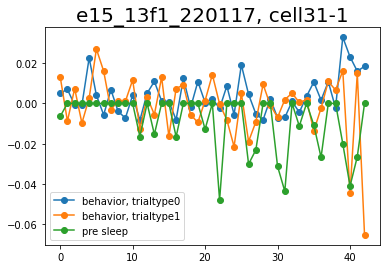

In [71]:
plt.plot(glm_res_df_all.loc[0]['coef'].loc[uid,field_id].values,label='behavior, trialtype0',marker='o')
plt.plot(glm_res_df_all.loc[1]['coef'].loc[uid,field_id].values,label='behavior, trialtype1',marker='o')
plt.plot(glm_res_df['coef'].values,label='pre sleep',marker='o')
plt.legend()
plt.title(f'{sess}, cell{uid}-{field_id}')

In [89]:
all_fields_one_sess=all_fields_recombined_all.loc[(ani,sess),:]

/tmp/ipykernel_252791/2137325102.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields_one_sess=all_fields_recombined_all.loc[(ani,sess),:]


In [103]:
reload(pp)
within_field_int_trial_df = pp.get_all_inh_within_field_all_pyr(all_fields_one_sess,fr_map_trial_df_int_combined)

In [162]:
reload(pp)
p_thresh = 0.05
mask = (glm_res_df_all['coef'] < 0) & (glm_res_df_all['p'] < p_thresh)

mean_within_field_int_trial_df_inh = pp.agg_int_within_field_all_pyr(within_field_int_trial_df,mask,ma_level=[2,4],other_level=[0,1,3])
mean_within_field_int_trial_df_all = pp.agg_int_within_field_all_pyr(within_field_int_trial_df,None,ma_level=[2,4],other_level=[0,1,3])


In [164]:
all_sw_with_metrics = all_sw_with_metrics_d_all.loc[(ani,sess)]

/tmp/ipykernel_252791/767816202.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_metrics = all_sw_with_metrics_d_all.loc[(ani,sess)]


In [175]:
per_field_metrics_one = per_field_metrics_all.loc[(ani,sess),:]

all_sw_with_metrics_oneti_with_inh_change= pp.add_inh_fr_change_to_all_sw(all_sw_with_metrics,mean_within_field_int_trial_df_inh.loc[ti],per_field_metrics_one,ti=0)




/tmp/ipykernel_252791/3189070663.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  per_field_metrics_one = per_field_metrics_all.loc[(ani,sess),:]


In [275]:
sw = 1
all_sw_with_metrics_oneti_with_inh_change_onesw = all_sw_with_metrics_oneti_with_inh_change.query('switch==@sw')

# inds=all_sw_with_metrics_oneti_with_inh_change_onesw.sort_values('inh_fr_change').index
# all_sw_with_metrics_oneti_with_inh_change_onesw.loc[inds].query('inh_fr_change<0')

ii=9
data_sub=all_sw_with_metrics_oneti_with_inh_change_onesw#.query('inh_fr_change>0').sort_values('inh_fr_change',ascending=False)
row=data_sub.iloc[ii]
tt,uid,field_id = row[['trialtype','uid','field_index']]
# r2 = r2_all.loc[tt,uid,field_id]
# print(r2)

In [276]:
X_pwc = X_pwc_all.loc[(ani,sess)]
X_raw = X_raw_all.loc[(ani,sess)]

/tmp/ipykernel_252791/3178725028.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_pwc = X_pwc_all.loc[(ani,sess)]
/tmp/ipykernel_252791/3178725028.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  X_raw = X_raw_all.loc[(ani,sess)]


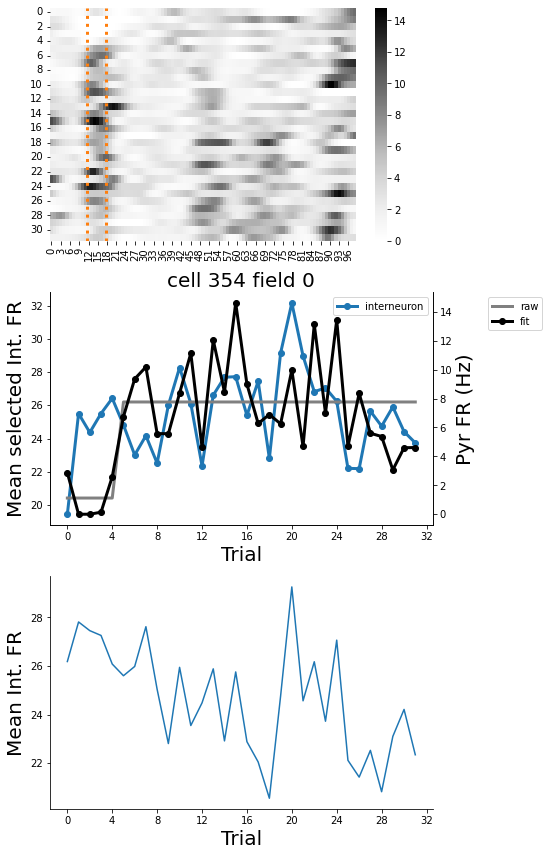

In [277]:
# plot
reload(pp)
# ti=0
fr_map_one_tt_predictor = fr_map_trial_df_int_combined.loc[(ti,tt)]

fr_map_trial_df_all_for_plot=fr_map_trial_df_pyr_combined

mean_within_field_pred = mean_within_field_int_trial_df_inh.loc[ti,tt,uid,field_id]
all_fields = all_fields_one_sess
do_weighted_pred=False
reload(pp)
fig,axs=pp.post_fit_plot(mean_within_field_pred,
            all_fields,fr_map_trial_df_all_for_plot,
            fr_map_one_tt_predictor,X_pwc,X_raw,
            ti,tt,uid,field_id,do_weighted_pred=do_weighted_pred
            )


Text(45.0, 0.5, 'Mean Pyr. FR')

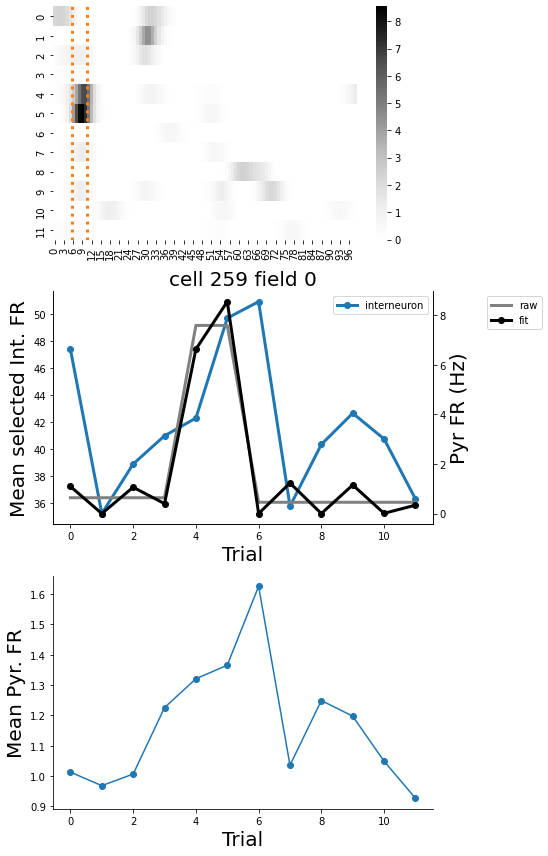

In [318]:
# plot
reload(pp)
# ti=0
# fr_map_one_tt_predictor = fr_map_trial_df_int_combined.loc[(ti,tt)]
fr_map_one_tt_predictor = fr_map_trial_df_pyr_combined.loc[(ti,tt)]

fr_map_trial_df_all_for_plot=fr_map_trial_df_pyr_combined

mean_within_field_pred = mean_within_field_int_trial_df_inh.loc[ti,tt,uid,field_id]
all_fields = all_fields_one_sess
do_weighted_pred=False
reload(pp)
fig,axs=pp.post_fit_plot(mean_within_field_pred,
            all_fields,fr_map_trial_df_all_for_plot,
            fr_map_one_tt_predictor,X_pwc,X_raw,
            ti,tt,uid,field_id,do_weighted_pred=do_weighted_pred
            )
axs[-1].set_ylabel('Mean Pyr. FR')

In [282]:
from matplotlib.ticker import MaxNLocator

In [314]:
sw = 1
all_sw_with_metrics_oneti_with_inh_change_onesw = all_sw_with_metrics_oneti_with_inh_change.query('switch==@sw')

# inds=all_sw_with_metrics_oneti_with_inh_change_onesw.sort_values('inh_fr_change').index
# all_sw_with_metrics_oneti_with_inh_change_onesw.loc[inds].query('inh_fr_change<0')

ii=17
data_sub=all_sw_with_metrics_oneti_with_inh_change_onesw#.query('inh_fr_change>0').sort_values('inh_fr_change',ascending=False)
row=data_sub.iloc[ii]
tt,uid,field_id = row[['trialtype','uid','field_index']]
# r2 = r2_all.loc[tt,uid,field_id]
# print(r2)

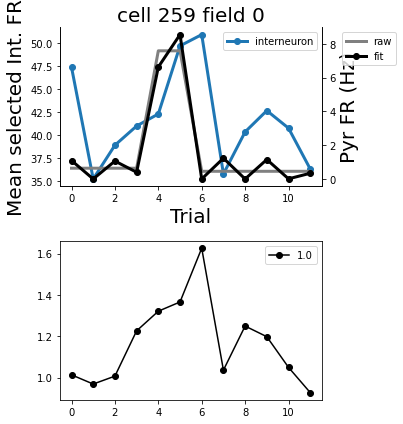

In [315]:
fig,axs=plt.subplots(2,1,figsize=(6,6))
ax=axs[0]
label = 'interneuron'
ylabel='Mean selected Int. FR'
mean_within_field_pred = mean_within_field_int_trial_df_inh.loc[ti,tt,uid,field_id]
if mean_within_field_pred is not None:
    mean_within_field_pred.plot(ax=ax,label=label,linewidth=3,marker='o')
ax2=ax.twinx()


ax2.plot(X_pwc.loc[ti,tt,uid,field_id].dropna().values,c='grey',label='raw',linewidth=3)
ax2.plot(X_raw.loc[ti,tt,uid,field_id].dropna().values,c='black',label='fit',marker='o',linewidth=3)
sns.despine(top=True,right=False,ax=ax)
sns.despine(top=True,right=False,ax=ax2)
ax.legend()
ax2.legend(bbox_to_anchor=[1.3,1])
ax.set(ylabel=ylabel,xlabel='Trial')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set(ylabel='Pyr FR (Hz)')
ax.set_title(f'cell {uid} field {field_id}')
plt.tight_layout()

ax=axs[1]
st,ed = all_fields.loc[(ti,tt,uid,field_id),['start','end']]
fr_map_trial_df_pyr_combined.loc[ti,tt,slice(None),st:ed].groupby(level=1).mean().T.plot(ax=ax,marker='o',color='k')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

<Axes: >

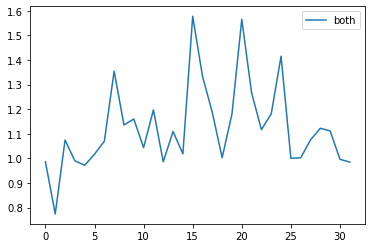

In [279]:


X_pwc_one=X_pwc.loc[(ti,tt,uid,field_id),:]
X_raw_one = X_raw.loc[(ti,tt,uid,field_id),:]

fig,axs=plt.subplots(2,1)



fr_map_trial_df_pyr_combined.loc[ti,tt,slice(None),st:ed].groupby(level=1).mean().T.plot()